# Mask R-CNN 示範

快速介紹如何使用預先訓練的模型來檢測和分割對象。

Ps. 由於官方版本的Python COCO tools有一個小bug會導致Python 3在操作時有錯誤產生, 因此在問題尚未被解決之前, 建議使用[[https://github.com/waleedka/coco](https://github.com/waleedka/coco)]的版本

在安裝編譯Python COCO tools的時候, 如果是Windows的平台則需要解決一些Windows上的坑, 詳請見[[Windows 10編譯Pycocotools踩坑記](http://www.jianshu.com/p/de455d653301)]

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize

%matplotlib inline 

# 專案的根目錄路徑
ROOT_DIR = os.getcwd()

# 用來儲存logs與trained model的目錄
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# 預訓練好的模型權重檔, 記得先下載並置放到專案根目錄
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# 如果沒找到訓練好的模型權重檔則自動下載預訓練好的COCO模型權重檔
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# 要被偵測的圖像所置放的目錄
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


## 設定 (Configurations)

我們將使用的模型是經過MS-COCO的資料集預訓練好的。這個模型的相關設定與參數標註在```coco.py```程式裡的```CocoConfig``` 類別。

為了對新圖像進行預測，我們將稍微修改一些設定。因此，我們將建立一個繼承``CocoConfig``的子類別並覆寫一些需要改變的屬性。

In [2]:
class InferenceConfig(coco.CocoConfig):
    # 將批處理大小設置為1，因為我們將將行預測
    # 一次一個圖像。批量大小= GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

## 創建模型並加載預訓練的權重

In [3]:
# 創建模型instance並設定為預測模式
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# 加載使用MS-COCO圖像資料集所預訓練的模型權重
model.load_weights(COCO_MODEL_PATH, by_name=True)

## 類別名稱 (Class Names)

這個模型將對圖像進行辨識來預測它是屬於那一種圖像類別並返回類別ID，這是識別每個類別的一個整數值ID。有些數據集用整數值來對應到每一種圖像類別，有些則不是。

例如，在MS-COCO數據集中，`person`類別ID是1，`teddy bear`ID是88。 這些ID通常是連續的，但並不總是如此。例如，COCO數據集有類別編號70和72，但卻沒有類別編號71。

為了提高一致性，同時支持來自多個不同來源的圖像數據訓練，我們的`Dataset`類別為每個圖像集的圖像類別分配了自己的順序整數ID。例如，如果您使用我們的`Dataset`類別來載入MS-COCO數據集，那麼`person`將獲得class ID = 1（就像COCO），而`teddy bear`則是78（與COCO不同） 。在將圖像類別ID映射到類別名稱時請記住這一點。

要獲得類別名稱的列表，你需要加載數據集，然後使用這樣的```class_names```屬性。

```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```


我們不想要為了運行這個範例就去下載整個COCO圖像數據集，所以我們在下面直接列出了COCO圖像類別名稱的列表。列表的索引代表它的ID（第一類為0，第二類為1，第三類為2，...等）。

In [4]:
# MS-COCO圖像類別名稱
# ** 與原始的 MS-COCO圖像類別相比, 這個列表多增加了一個"BG(背景)"類別 **

# 列表中的索引是在這個模型中使用的ID。例如，要獲得'teddy bear'的ID
# 使用: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## 進行圖像物件檢測 (Object Detection)

Processing 1 images
image                    shape: (415, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


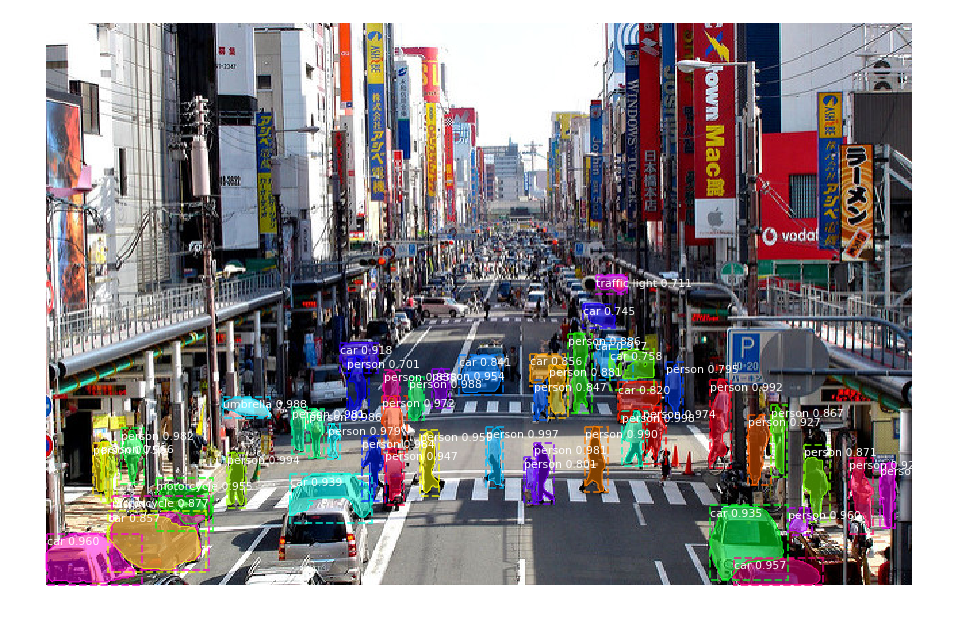

In [5]:
# 從圖像文件夾中隨機加載一個圖像
file_names = next(os.walk(IMAGE_DIR))[2] # 取得目錄下所有的圖像檔名

# 讀進圖像
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# 進行圖像物件偵測
results = model.detect([image], verbose=1)

# 檢測結果包含了:
#   - class_ids 所有偵測出來的物件的ID列表
#   - masks 所有偵測出來的物件的遮罩(mask)
#   - rois 所有偵測出來的感興趣區域(region of interest)
#   - score 
r = results[0]

# 視覺化
# "visualize.display_instances"
# 一個簡單把邊界框/物件遮罩與預測結果打印到原始圖像(BGR)上的工具函式
"""視覺展示每個被偵測出來的物件個體
    display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None)
                      
    參數:
        image: 原始的圖像
        boxes: [num_instance, (y1, x1, y2, x2)] in image coordinates.
        masks: [height, width, num_instances] 每個被偵測出來的物件個體的遮罩
        class_ids: [num_instances] 每個被偵測出來的物件個體的圖像類別ID
        class_names: 數據集的圖像類別名稱列表
        scores: (optional) confidence scores for each box
        figsize: (optional) the size of the image.
"""
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])